Blockbusting in the 21st Century?: Minority Move-ins and Neighborhood Home Value Appreciation
===

## Introduction


Housing discrimination has, in one way or another, existed in the United States since independence. After reconstruction, several tactics became commonplace, including racial deed covenants, and redlining. Across the nation, there was evidence of “white flight”, or the movement of whites out of neighborhoods with minorities due to fears over home value depreciation or other factors. Real-estate agents commonly attempted to abuse these fears with a tactic known as “blockbusting” in which they would spread fear over minority-move-ins leading to a fire sale of homes in a neighborhood (Rothstein, 2017).

Much has been researched about the modern-day effects of these past tactics, whether in deed covenants leading to improved relative neighborhood quality (Sood, Ehrman-Solberg, 2024), or redlining leading to localized areas of higher poverty (Appel, Nickerson, 2016), or simply lower quality of opportunity in majority-black neighborhoods (Chetty, et al, 2014). There is also evidence of modern-day tactics still occurring in the housing market, whether in lending markets (Quillian, Lee, Honoré, 2020), or in real estates continuing to practice “racial steering”, the process of, whether knowing it or not, primarily showing people of minority groups neighborhoods that are also primarily of that minority group (Glenn, 2018)

This paper seeks to contribute to this literature by analyzing the modern accuracy of the perceived link that 50’s era blockbusting relied on – do minority move-ins suppress home-value appreciation? I use loan data from [**Fannie Mae (FNMA) \& Freddie Mac (FHLMC)**](https://web.archive.org/web/20240914151448/https://www.fhfa.gov/data/single-family-census-tract-file) to provide data on neighborhood move-ins, [**(ACS)**](https://www.nhgis.org/) data to normalize, and [(**Zillow ZHVI**)](https://www.zillow.com/research/data/) data to show the change in home prices. My study has the following methodology:

First, I select zip codes with move-ins during the 2009-2010 period (Initial Period) that are majority white (we are uninterested in the effect on majority-minority neighborhoods), and in metropolitan statistical areas (necessary for appreciation normalization). I take the “minority move-in share”, or the ratio of loans for new purchases made in that zip code to minorities, and then look at those same zip codes over the 2012-2013 period (Treatment Period) and analyze what “treatment” was applied (the difference in minority move-in share from the previous period), which is our main explanatory variable. Next, we analyze the association between the change in minority move-in-share and the future appreciation in home prices, relative to their MSA average, for the next 6 years (ending in 2019). This should inform us what the effect of a sudden increase in minority move-ins is on home value appreciation. 

I find that the effect of an increase in minority move-in share on home-value appreciation is unclear, relative to the metropolitan statistical area. While the mean home value appreciation does decrease in the treatment group relative to the control, there is an incredibly high degree of variation in the data.

## Data Loading

### Loading Loan Data

We start by loading libraries. For dataframes we are using `pandas`, for plots we are using `pyplot` from `matplotlib`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Because the data is in ``.txt`` format, with no column headers, and is in many different files for different years and loan types, some light data cleaning is required. To begin, we set up short titles for each column based on the data dictionary provided, and create a list of columns we do not need.

In [2]:
def read_columns_from_txt(filename):
    data = {}
    with open(filename, "r") as f:
        for line in f:
            key, value = line.split("=", 1)
            data[key.strip()] = eval(value.strip())
    return data

columns_data = read_columns_from_txt("data/columns.txt")
cols = columns_data["cols"]
cols_pre2018 = columns_data["cols_pre2018"]
dropcols = columns_data["dropcols"]
dropcols_pre2018 = columns_data["dropcols_pre2018"]
cols_2013 = columns_data["cols_2013"]

We next must load our data using these columns. I create a `load_loans` method to make it easier to modify the years we load. For this project, we are focusing on some of the earliest base years possible (primarily due to computing constraints). In the future, I am interested in looking at moving base years.

In [3]:
def load_loans(years):
    loans_list = []
    for year in years:
        if year >= 2018: # The data format changes in 2018
            files = [f"data/sf/fhlmc_sf{year}c_loans.txt", f"data/sf/fnma_sf{year}c_loans.txt"]
            loans_year = pd.concat(
                [pd.read_csv(file, sep=r"\s+", header=None, names=cols).drop(columns=dropcols) for file in files],
                ignore_index=True
            )
        else:
            files = [f"data/sf/fhlmc_sf{year}c_loans.txt", f"data/sf/fnma_sf{year}c_loans.txt"]
            loans_year = pd.concat(
                [pd.read_csv(file, sep=r"\s+", header=None, names=cols_2013).drop(columns=dropcols_pre2018) for file in files],
                ignore_index=True
            )
        loans_year["year"] = year
        loans_list.append(loans_year)
        print(f"Processed {year}", end=" ")
    return pd.concat(loans_list, ignore_index=True)

In [4]:
loans = load_loans([2009, 2010, 2012, 2013]) # Please forgive the print statement! The full data can take upwards of 20 mins to load.

Processed 2009 Processed 2010 Processed 2012 Processed 2013 

I picked 2011 and 2012 as my "lending years" as they are some of the earliest possible years after the financial crisis. I picked 2019 as my final "test" year as it is the last year before COVID.

Next, we analyze each loan to determine how many "minority move-ins" it corresponds to. For the purposes of this project, a "minority move-in" refers to a new home purchase by a black or hispanic borrower or coborrower

### Cleaning Loan Data

In [5]:
loans = loans[loans['purpose'] == 1]

In [6]:
# Define race and ethnicity sets
races_set = {3}
ethnicities_set = {1}

# Extract relevant borrower and co-borrower race/ethnicity columns
borrower_races = loans[[col for col in loans.columns if col.startswith("borrower_race")]]
coborrower_races = loans[[col for col in loans.columns if col.startswith("coborrower_race")]]
borrower_ethnicities = loans[[col for col in loans.columns if col.startswith("borrower_ethnicity")]]
coborrower_ethnicities = loans[[col for col in loans.columns if col.startswith("coborrower_ethnicity")]]

# Check if any race or ethnicity belongs to minority groups
borrower_minority = borrower_races.isin(races_set).any(axis=1) | borrower_ethnicities.isin(ethnicities_set).any(axis=1)
coborrower_minority = coborrower_races.isin(races_set).any(axis=1) | coborrower_ethnicities.isin(ethnicities_set).any(axis=1)

# Assign values efficiently
loans["early_mmi"] = np.where((loans["year"] < 2011) & (borrower_minority & coborrower_minority), 2,
                              np.where((loans["year"] < 2011) & (borrower_minority | coborrower_minority), 1, 0))
loans["late_mmi"] = np.where((loans["year"] > 2011) & (borrower_minority & coborrower_minority), 2,
                             np.where((loans["year"] > 2011) & (borrower_minority | coborrower_minority), 1, 0))

loans["early_move_ins"] = np.where(loans["year"] < 2011, 1, 0)
loans["late_move_ins"] = np.where(loans["year"] > 2011, 1, 0)

Finally, we add a column with the full census tract code for future merging

In [19]:
loans['longtract'] = (
    loans['state_fips'].astype(str).str.zfill(2) + 
    loans['county_fips'].astype(str).str.zfill(3) + 
    loans['census_tract'].apply(lambda x: f"{int(x):06d}" if x == int(x) else f"{x:06.2f}".replace('.', ''))
)

### Merging

To truly understand the rate of minority move-ins, we must control for neighborhood demographics. The **2020 US Census Data** provides this information (total population, white population, black population)

In [20]:
cols_tract = ['YEAR', 'ZCTAA','U7J001', 'U7J002', 'U7J003', 'U7J004', 'U7J005', 'U7J006', 'U7J007', 'U7J008']
tract_data = pd.read_csv('data/census/nhgis0009_ds258_2020_zcta.csv')[cols_tract]
tract_data.rename(columns={
    'YEAR': 'year',
    'ZCTAA': 'zip', 
    'U7J001': 'total_pop', 
    'U7J002': 'white', 
    'U7J003': 'black', 
    'U7J004': 'native_american', 
    'U7J005': 'asian', 
    'U7J006': 'pacific_islander', 
    'U7J007': 'other_race', 
    'U7J008': 'two_or_more'}, inplace=True)

Next, we load in the Zillow data for information about home prices

In [21]:
zhvi = pd.read_csv('data/zhvi/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month (1).csv')

The Zillow data is based on zip-code, but all our other data is based on census tract. As a result, we use a Crosswalk File from HUD.

In [22]:
crosswalk = pd.read_excel('data/census/ZIP_TRACT_122024.xlsx')

Next, we merge the loan data into our crosswalk. We aggregate on each census tract.

In [23]:
loans_grouped = loans.groupby(['longtract', 'msa_code'])[['early_mmi', 'late_mmi', 'early_move_ins', 'late_move_ins']].sum().reset_index()
loans_grouped['longtract'] = loans_grouped['longtract'].astype(str).str.zfill(11)
crosswalk['TRACT'] = crosswalk['TRACT'].astype(str).str.zfill(11)
loans_grouped['longtract'] = loans_grouped['longtract'].str.rstrip('.0')
loans_crosswalk = loans_grouped.merge(crosswalk, left_on='longtract', right_on='TRACT', how='outer')

Now that we have loan data, we merge with our **Census data**, and then filter for areas that are majority white.

In [24]:
loans_census = loans_crosswalk.merge(tract_data, left_on='ZIP', right_on='zip', how='left')
threshold_white = 0.5  # We only look at areas that are majority white
loans_census_filter = loans_census[(loans_census['white'] / loans_census['total_pop'] > threshold_white)]

Now we merge **Zillow data**, and find the change in home values of an area from 2010 to 2019 (End of early move-in data until COVID)

In [25]:
loans_zhvi = loans_census_filter.merge(zhvi, left_on='zip', right_on='RegionName', how='left')
loans_zhvi[f'avg_value_2010'] = loans_zhvi[[f'2010-10-31', f'2010-11-30', f'2010-12-31']].mean(axis=1)
for year in range(2011, 2020):
    loans_zhvi[f'avg_value_{year}'] = loans_zhvi[[f'{year}-10-31', f'{year}-11-30', f'{year}-12-31']].mean(axis=1)
    loans_zhvi[f'value_ratio_{year}'] = loans_zhvi[f'avg_value_{year}'] / loans_zhvi[f'avg_value_2010']
loans_zhvi = loans_zhvi.drop(columns=[col for col in loans_zhvi.columns if col[:4].isdigit()])

Next, we control for metropolitan area.

In [26]:
# Calculate the average value change per msa_code for each year in the range
for year in range(2011, 2020):
    loans_zhvi[f'msa_avg_value_ratio_{year}'] = loans_zhvi.groupby('msa_code')[f'value_ratio_{year}'].transform('mean')
    loans_zhvi[f'value_diff_{year}'] = loans_zhvi[f'value_ratio_{year}'] - loans_zhvi[f'msa_avg_value_ratio_{year}']

In [27]:
# loans_zhvi = loans_zhvi.drop(columns=['longtract', 'TRACT', 'RegionName', 'black', 'native_american', 'asian', 'pacific_islander', 'StateName', 'State', 'City', 'Metro', 'CountyName', 'SizeRank', 'RegionID'])
data_table = loans_zhvi.groupby('zip').agg({
    'total_pop': 'sum',
    'msa_code': 'min',
    'early_mmi': 'sum',
    'late_mmi': 'sum',
    'early_move_ins': 'sum',
    'late_move_ins': 'sum',
    'white': 'sum',
    'other_race': 'sum',
    'two_or_more': 'sum',
    'avg_value_2010': 'mean',
    'avg_value_2011': 'mean',
    'value_ratio_2011': 'mean',
    'avg_value_2012': 'mean',
    'value_ratio_2012': 'mean',
    'avg_value_2013': 'mean',
    'value_ratio_2013': 'mean',
    'avg_value_2014': 'mean',
    'value_ratio_2014': 'mean',
    'avg_value_2015': 'mean',
    'value_ratio_2015': 'mean',
    'avg_value_2016': 'mean',
    'value_ratio_2016': 'mean',
    'avg_value_2017': 'mean',
    'value_ratio_2017': 'mean',
    'avg_value_2018': 'mean',
    'value_ratio_2018': 'mean',
    'avg_value_2019': 'mean',
    'value_ratio_2019': 'mean',
    'msa_avg_value_ratio_2011': 'mean',
    'value_diff_2011': 'mean',
    'msa_avg_value_ratio_2012': 'mean',
    'value_diff_2012': 'mean',
    'msa_avg_value_ratio_2013': 'mean',
    'value_diff_2013': 'mean',
    'msa_avg_value_ratio_2014': 'mean',
    'value_diff_2014': 'mean',
    'msa_avg_value_ratio_2015': 'mean',
    'value_diff_2015': 'mean',
    'msa_avg_value_ratio_2016': 'mean',
    'value_diff_2016': 'mean',
    'msa_avg_value_ratio_2017': 'mean',
    'value_diff_2017': 'mean',
    'msa_avg_value_ratio_2018': 'mean',
    'value_diff_2018': 'mean',
    'msa_avg_value_ratio_2019': 'mean',
    'value_diff_2019': 'mean',
}).reset_index()
data_table['early_mmi_ratio'] = data_table['early_mmi'] / data_table['early_move_ins']
data_table['late_mmi_ratio'] = data_table['late_mmi'] / data_table['late_move_ins']
data_table['early_late_ratio'] = data_table['late_mmi_ratio'] - data_table['early_mmi_ratio'] # Positive: MMI higher in late period

We have now, finally loaded our data. We have our quantity of minority move-ins, previous demographic makeup of the neighborhood, previous home values, and home values after a few years. 

## Summary Statistics

In our `filtered_data` table, we have information about our explanatory variables (demographics), our independent variables (initial property value), and our outcome variable (final property value)

In [122]:
prop_values_summary = data_table[['early_mmi','late_mmi','early_move_ins', 'late_move_ins']].describe().round(2)
prop_values_summary.columns = ['Minority Move-Ins (Initial Period)','Minority Move-Ins (Treatment Period)', 'Total Move-Ins (Initial Period)', 'Total Move-Ins (Treatment Period)']
prop_values_summary.index = ['Count', 'Mean', 'Standard Deviation', 'Minimum', '25th Percentile', 'Median', '75th Percentile', 'Maximum']
prop_values_summary.loc['Range'] = prop_values_summary.loc['Maximum'] - prop_values_summary.loc['Minimum']
prop_values_summary.loc['Count'] = prop_values_summary.loc['Count'].astype(int)

# Styling
styled_prop_vals = prop_values_summary.style.set_caption("Table 1: Move-In and Minority Move-In by Zip Code")

# Apply table styles
styled_prop_vals = styled_prop_vals.set_table_attributes('style="width: 50%; margin: auto;"')

# Apply formatting
prop_values_summary['Minority Move-Ins (Initial Period)'] = prop_values_summary['Minority Move-Ins (Initial Period)'].astype(int)
prop_values_summary['Minority Move-Ins (Treatment Period)'] = prop_values_summary['Minority Move-Ins (Treatment Period)'].astype(int)
prop_values_summary['Total Move-Ins (Initial Period)'] = prop_values_summary['Total Move-Ins (Initial Period)'].astype(int)
prop_values_summary['Total Move-Ins (Treatment Period)'] = prop_values_summary['Total Move-Ins (Treatment Period)'].astype(int)

# Caption formatting
styled_prop_vals = styled_prop_vals.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('caption-side', 'top'),
        ('font-size', '20px'),
        ('font-style', 'italic'),
        ('text-align', 'center'),
        ('color', '#222')
    ]
}])

styled_prop_vals

,Minority Move-Ins (Initial Period),Minority Move-Ins (Treatment Period),Total Move-Ins (Initial Period),Total Move-Ins (Treatment Period)
Count,28748,28748,28748,28748
Mean,0,4,11,58
Standard Deviation,2,13,35,147
Minimum,0,0,0,0
25th Percentile,0,0,0,0
Median,0,0,0,0
75th Percentile,0,1,0,38
Maximum,91,362,641,1961
Range,91,362,641,1961


This table shows one of the difficulties of the project, many majority-white zip codes inside of metropolitan areas either do not have many or have no minority-move ins (or any move-ins). As you can see, in the initial period, the 75th percentile zip code had zero move-ins. For all following tables and graphs, we are only looking at zip codes that had move-ins during both periods. This could lead to bias, but it aligns with the research question, so it should not meaningfully change our conclusion.

In [125]:
# Select value difference columns
value_diff_cols = [col for col in data_table.columns if col.startswith('value_diff_')]

# Create readable column names
renamed_cols = {col: f"Home Value Change {col.split('_')[-1]}" for col in value_diff_cols}

# Compute summary statistics
summary_stats = data_table[value_diff_cols].describe().round(10)

# Convert to DataFrame (ensuring correct format)
summary_df = pd.DataFrame(summary_stats)

# Rename columns for better readability
summary_df = summary_df.rename(columns=renamed_cols)

# Rename index for better readability
summary_df.index.names = ['Statistic']
# Adjust rounding for better readability
# Ensure 'Count' is integer
summary_df.loc['count'] = summary_df.loc['count'].astype(int)
summary_df = summary_df.T
# Styling
styled_summary = summary_df.style.set_caption("Table 2: Summary Statistics of Home Value Changes by Year")

# Center the table and adjust width
styled_summary = styled_summary.set_table_attributes('style="width: 80%; margin: auto;"')
# Ensure 'count' is integer
summary_df['count'] = summary_df['count'].astype(int)
# Format table caption
styled_summary = styled_summary.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('caption-side', 'top'),
        ('font-size', '20px'),
        ('font-style', 'italic'),
        ('text-align', 'center'),
        ('color', '#222')
    ]
}])

# Display styled DataFrame
styled_summary

Statistic,count,mean,std,min,25%,50%,75%,max
Home Value Change 2011,8971,0.001599,0.032448,-0.236082,-0.013639,0.002794,0.017987,0.273739
Home Value Change 2012,8971,0.002087,0.051499,-0.412998,-0.023653,0.002332,0.028512,0.379845
Home Value Change 2013,8971,0.000775,0.067734,-0.476977,-0.033969,-0.000104,0.035514,0.458202
Home Value Change 2014,8971,0.001347,0.081513,-0.540733,-0.041143,-0.001712,0.039774,0.823827
Home Value Change 2015,8971,0.002431,0.098838,-0.628896,-0.048556,-0.002640,0.045117,1.128573
Home Value Change 2016,8971,0.001695,0.115651,-0.706582,-0.057488,-0.004824,0.048524,1.474979
Home Value Change 2017,8971,0.002696,0.134817,-0.706928,-0.066070,-0.005925,0.053803,1.776770
Home Value Change 2018,8971,0.003659,0.154999,-0.836585,-0.074531,-0.007726,0.061206,1.922465
Home Value Change 2019,8971,0.005287,0.167264,-0.809886,-0.080652,-0.007977,0.068882,2.062908


It should not be surprising that the median and mean are basically zero. Recall that we are normalizing home-value change to the metropolitan area's home-value change. It should also be unsurprising that the ranges increase over time. The difference between a neighborhood and metro area will be more obvious over time. This table has significantly fewer observations than the table above, due to the unpredictable availability of the Zillow data. The move-in data is not significantly different between the zip codes with Zillow data and the zip codes without, so we will drop the zip codes without Zillow data.

## Plots \& Figures

### Time Series of $Y$ With Discrete $X$

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\emers\AppData\Local\Temp\ipykernel_28008\283321176.py:9: SyntaxWarning: invalid escape sequence '\d'
  melted_data['year'] = melted_data['year'].str.extract('(\d+)').astype(int)


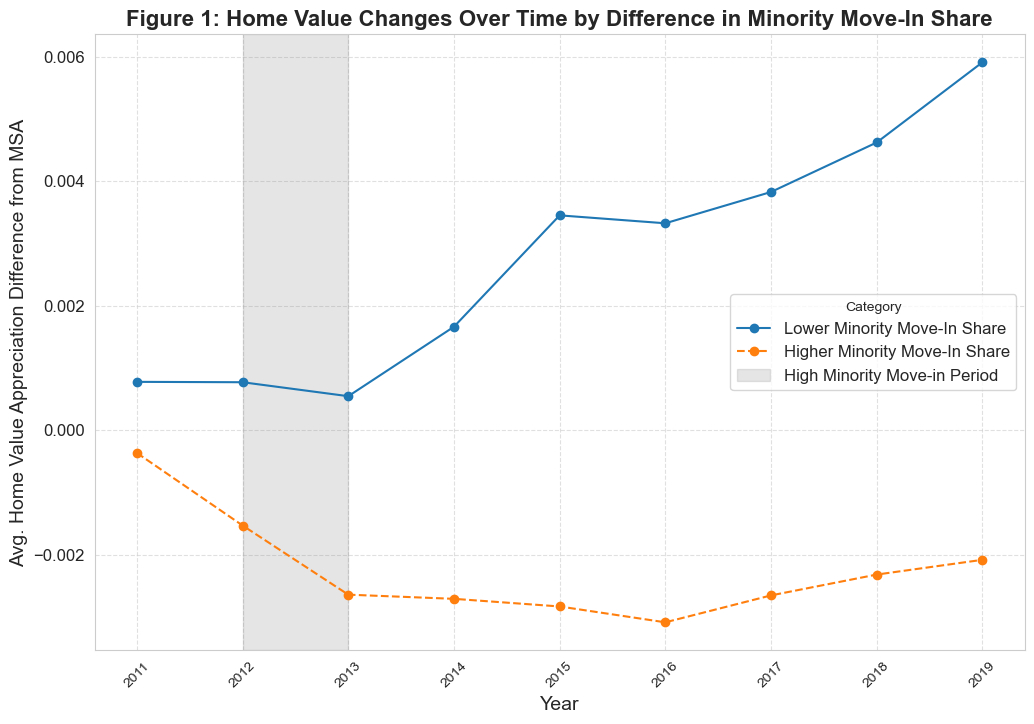

In [128]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
# Categorize early_late_ratio into high and low
data_table['early_late_category'] = pd.cut(data_table['early_late_ratio'], bins=[-float('inf'), 0.00, float('inf')], labels=['lower', 'higher'])

# Melt the dataframe for easier plotting
melted_data = data_table.melt(id_vars=['early_late_category'], value_vars=[col for col in data_table.columns if col.startswith('value_diff_')], var_name='year', value_name='value_diff')
# Extract numeric year
melted_data['year'] = melted_data['year'].str.extract('(\d+)').astype(int)
# Compute average value difference per category and year
avg_value_change = melted_data.groupby(['early_late_category', 'year'], observed=False)['value_diff'].mean().reset_index()

# Define colors
colors = {"lower": "#1f77b4", "higher": "#ff7f0e"}  # Blue for low, Orange for high
linestyles = {"lower": "solid", "higher": "dashed"}  # Solid & dashed lines

# Plot each category with distinct styling
for category, data in avg_value_change.groupby('early_late_category', observed=False):
    plt.plot(data['year'], data['value_diff'], label=f'{category.capitalize()} Minority Move-In Share', color=colors[category], linestyle=linestyles[category], marker='o')

# Add shaded area for high minority move-in period
plt.axvspan(2012, 2013, color='gray', alpha=0.2, label='High Minority Move-in Period')

# Labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Avg. Home Value Appreciation Difference from MSA', fontsize=14)
plt.title('Figure 1: Home Value Changes Over Time by Difference in Minority Move-In Share', fontsize=16, fontweight='bold')

# Improved legend
plt.legend(title='Category', fontsize=12)
plt.xticks(range(avg_value_change['year'].min(), avg_value_change['year'].max() + 1), rotation=45)
plt.yticks(fontsize=12)

# Grid styling
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

This graph shows that home values with more minority move-ins in during the treatment period (2012-2013) than in the initial period (2009-2010) already had a drop-off in value prior to the minority move-ins, and continued it after 2013 relative to their metro area and relative to homes that had fewer minority move-ins. This effect appears to be somewhat temporary, as they begin increasing again after 2016.

### Scatterplot of Main $X$ and $Y$

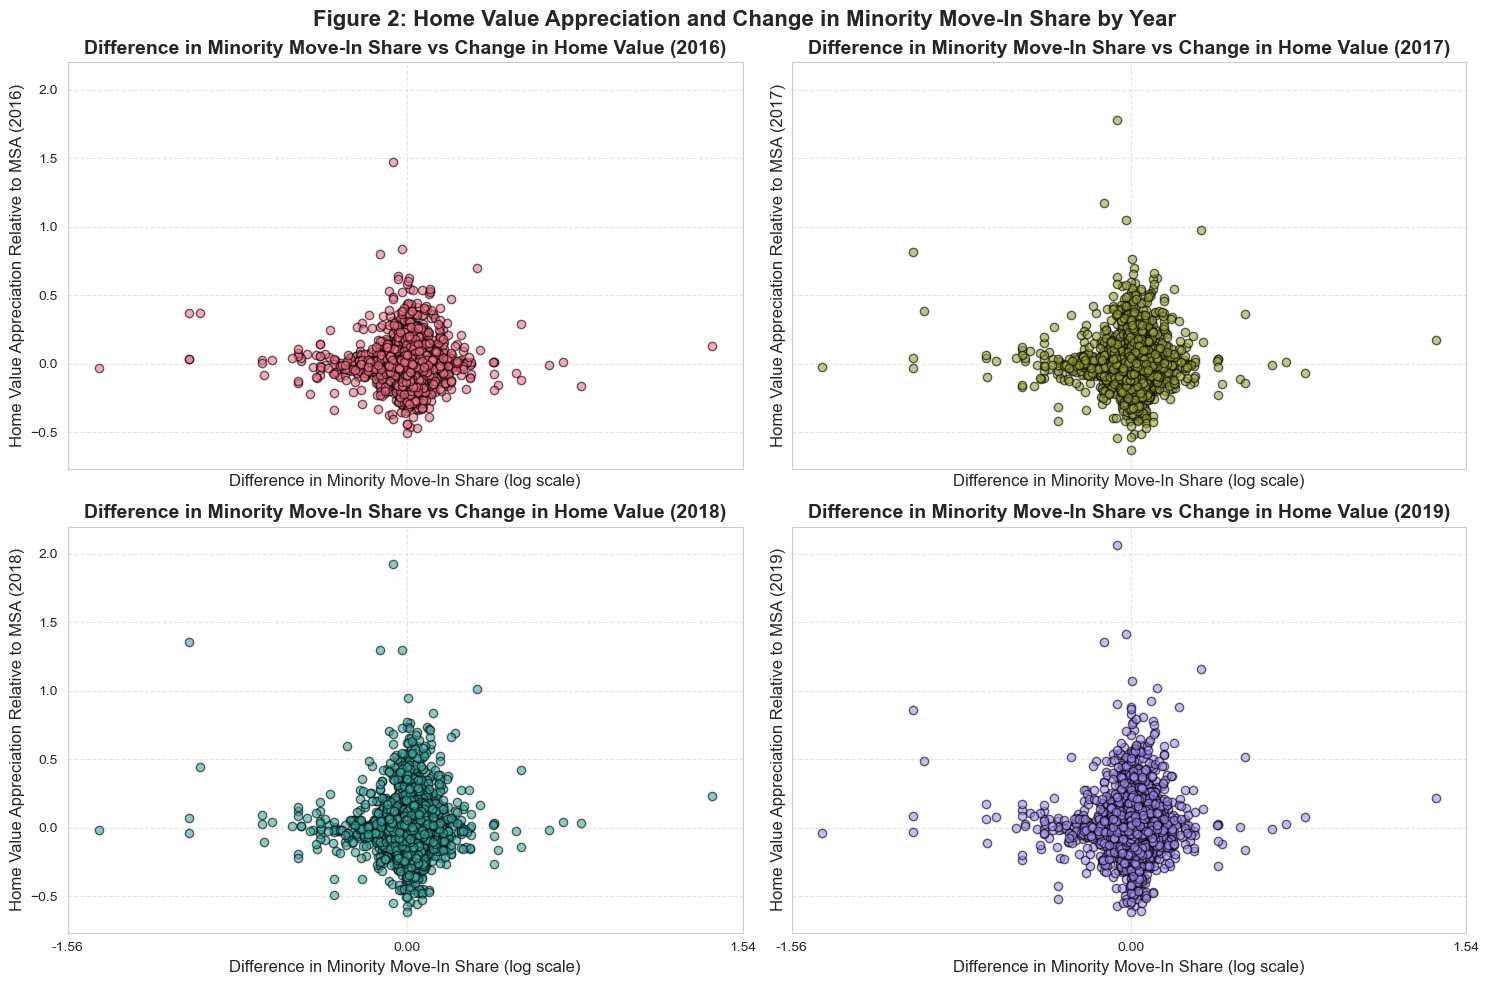

In [141]:
# Filter data
filtered_data = data_table[data_table['total_pop'].abs() > 100]

# Define color palette
colors = sns.color_palette("husl", 4)  # Distinct colors for better visibility

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

years = [2016, 2017, 2018, 2019]
for i, year in enumerate(years):
    ax = axs[i // 2, i % 2]
    
    # Scatter plot with improved aesthetics
    ax.scatter(
        filtered_data['early_late_ratio'], 
        filtered_data[f'value_diff_{year}'], 
        alpha=0.6, color=colors[i], edgecolor='black'
    )
    ax.set_xscale('symlog')
    
    # Titles and labels
    ax.set_title(f'Difference in Minority Move-In Share vs Change in Home Value ({year})', fontsize=14, fontweight='bold')
    ax.set_xlabel('Difference in Minority Move-In Share (log scale)', fontsize=12)
    ax.set_ylabel(f'Home Value Appreciation Relative to MSA ({year})', fontsize=12)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
    # Grid styling
    ax.grid(True, linestyle="--", alpha=0.5)
# Improve layout
fig.suptitle('Figure 2: Home Value Appreciation and Change in Minority Move-In Share by Year', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


While Figure 1 indicates that at first there is some degree of negative association between an increase in minority move-in share and home appreciation relative to MSA, Figure 2 shows that data has a high degree of variation, so it's hard to say that there truly is any association. This graph shows that the variation increases as 

### Box Plot With Discrete $X$

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
C:\Users\emers\AppData\Local\Temp\ipykernel_28008\2977639808.py:6: SyntaxWarning: invalid escape sequence '\d'
  melted_data['year'] = melted_data['year'].str.extract('(\d+)').astype(int)


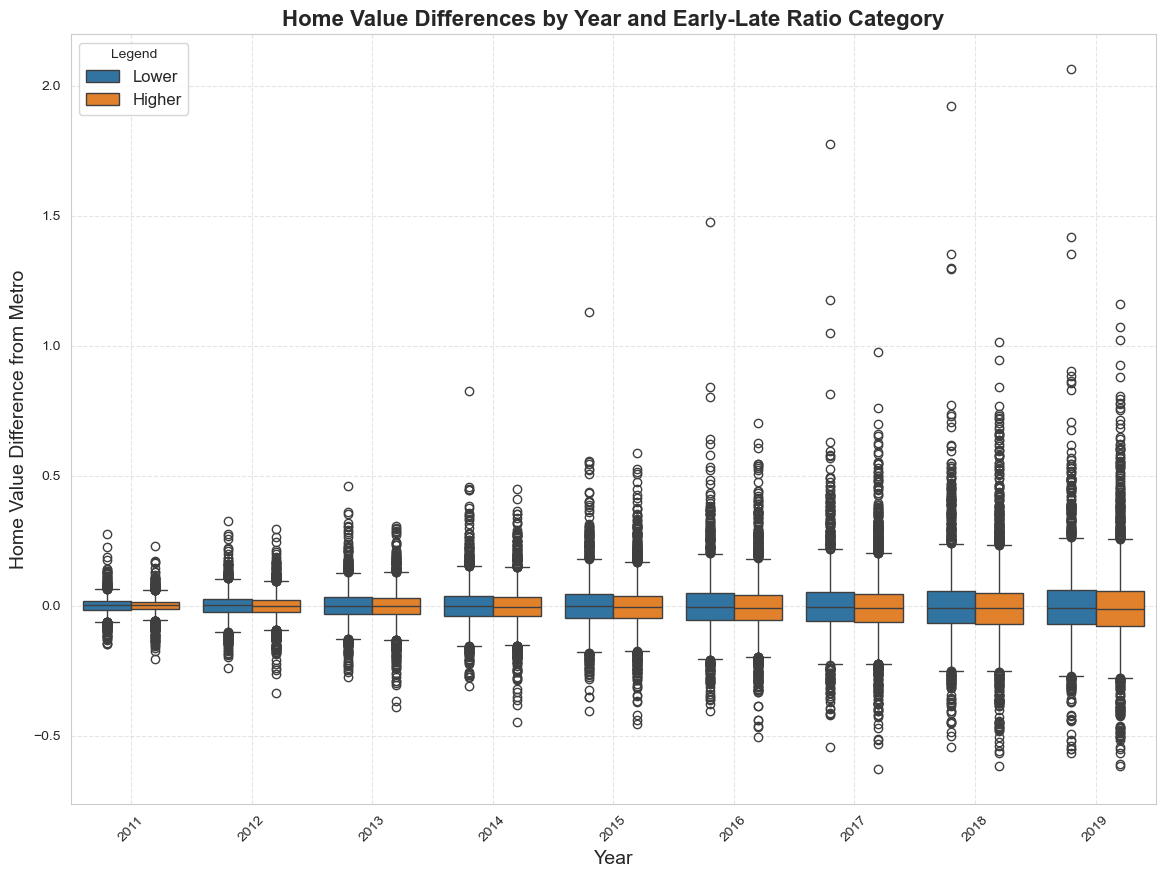

In [ ]:
data_table['early_late_category'] = pd.cut(data_table['early_late_ratio'], bins=[-float('inf'), 0.00, float('inf')], labels=['Lower', 'Higher'])

# Melt the dataframe for easier plotting
melted_data = data_table.melt(id_vars=['early_late_category'], value_vars=[col for col in data_table.columns if col.startswith('value_diff_')], var_name='year', value_name='value_diff')
# Extract numeric year
melted_data['year'] = melted_data['year'].str.extract('(\d+)').astype(int)
# Compute average value difference per category and year
avg_value_change = melted_data.groupby(['early_late_category', 'year'], observed=False)['value_diff'].mean().reset_index()
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(14, 10))
sns.boxplot(x='year', y='value_diff', hue='early_late_category', data=melted_data, palette={"Lower": "#1f77b4", "Higher": "#ff7f0e"})

# Add labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Home Value Difference from Metro', fontsize=14)
plt.title('Home Value Differences by Year and Early-Late Ratio Category', fontsize=16, fontweight='bold')
plt.legend(title='Legend', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

As this graph shows, there is an increidbly high degree of variation in home values relative to the metropolitan area, much of which cannot be explained by the change in minority move-in share.

### Final Graph

## Conclusion

In this paper, I analyze the link between an increase in the share of minority move-ins and home values on a neighborhood level. I construct a table of zip codes that includes, from federal loan underwriting data, the share of minority move-ins in the initial period, and the share of minority move-ins in the treatment period. The table also includes Zillow data showing the change in home values. I normalize this change in home values to the MSA the zip code is in, and the initial home values. 

My findings indicate that there is slight, if any association between my an increase in minority move-ins and home values, at least on a zip-code level. I am unable, with this level of data and analysis, to conclude the extent to which an increase in minority move-ins can explain any future change in home values. This is while controlling for iniital home values and MSA-level home value appreciation.

## References

Manson, S., Schroeder, J., Van Riper, D., Knowles, K., Kugler, T., Roberts, F., & Ruggles, S. (2024). *National Historical Geographic Information System: Version 19.0* [Dataset]. Minneapolis, MN: IPUMS. https://doi.org/10.18128/D050.V19.0